In [1]:
"""
Model
"""
import os
import csv
import math
import numpy as np
import cv2
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Activation, Dropout, Conv2D, Flatten, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


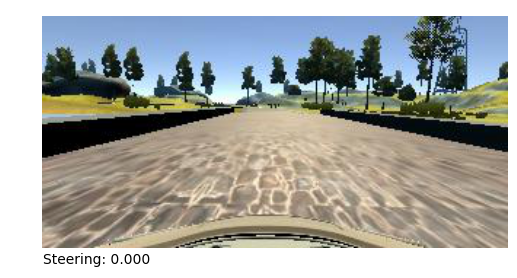

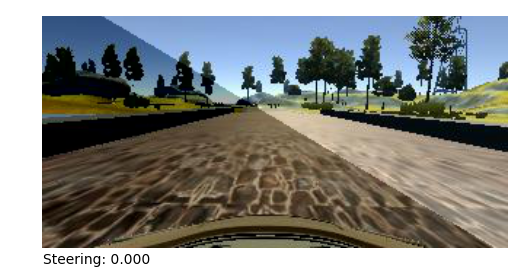

In [45]:
LABELS_FILENAME = 'data/driving_log.csv'
def enumDrivingLog(driving_log_fname):
    with open(driving_log_fname, 'r') as labels_file:
        rdr=csv.DictReader(labels_file)
        for row in rdr:
            yield row

def filterDrivingLog(src, threshold, prob):
    for row in src:
        steering = float(row['steering'])
        if abs(steering) > threshold or np.random.randint(0,100) <= prob:
            yield row


def genAugmentedViews(src):
    for row in src:
        steering = float(row['steering'])
        center = readImage(row['center'])
        left = readImage(row['left'])
        right = readImage(row['right'])
        
        # crop
        
        # adjust steering for left and right cameras
        left_steer = steering + 0.25
        right_steer = steering - 0.25
        #print('center %.2f, left: %.2f, right: %.2f' % (steering, left_steer, right_steer) )
    
        yield (center, steering)
        #yield (left, left_steer)
        #yield (right, right_steer)
        
        yield (addShadow(center), steering)
        
        #yield (cv2.flip(center, 1), steering * -1.)
        
        #yield (adjustBrightness(center, 2), steering)
        #yield (adjustBrightness(center, 3), steering)
        #yield (adjustBrightness(left, 2), left_steer)
        #yield (adjustBrightness(left, 3), left_steer)
        #yield (adjustBrightness(right, 2), right_steer)
        #yield (adjustBrightness(right, 3), right_steer)
    
def addShadow(img):
    y,u,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))
    y = y.astype(np.int32)
    mask = np.zeros(y.shape, dtype=np.int32)
    
    x1 = np.random.uniform() * y.shape[1]
    x2 = np.random.uniform() * y.shape[1]
    slope = float(y.shape[0]) / (x2 - x1)
    intercept = -(slope * x1)
    for j in range(mask.shape[0]):
        for i in range(mask.shape[1]):
            if j > (i*slope)+intercept:
                mask[j,i] -= 80

    y += mask
    y = np.clip(y, 0,255).astype(np.uint8)
    return cv2.cvtColor(cv2.merge((y,u,v)), cv2.COLOR_YCrCb2RGB)
                
def adjustBrightness(img, d):
    h,s,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
    return cv2.cvtColor(cv2.merge((h,s,v // d)), cv2.COLOR_HSV2RGB)
        
def genNormalizedData(src):
    for img,steering in src:
        normImg = normalizeImage(convColorSpace(img))
        normSteering = round(steering,2) / 2.
        #print('steer: %.3f, normSteer: %.3f' % (steering, normSteering ))
        yield (normImg, normSteering)
        
"""
Operations done for every image - both training and predictions
"""

def readImage(img_fname):
    img_path = os.path.join('data',img_fname.strip())
    img = cv2.imread(img_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def convColorSpace(img):
    #y,u,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))
    #return cv2.merge((y,u,v))
    return img

def cropImage(img):
    return img

def normalizeImage(img):
    nImg = ((img / 255.0) - 0.5).astype(np.float32)
    return nImg

def imgForDisplay(img):
    return ((img + 0.5) * 255).astype(np.uint8)

data = list(filterDrivingLog(enumDrivingLog(LABELS_FILENAME), 0.01, 25))

# split into train and validation
#train, test = train_test_split(data, test_size=0.25)
#train = shuffle(train)
train = data

imageGenerator = genNormalizedData(genAugmentedViews([train[0]]))

#print(len(list(imageGenerator)))

for normImg,normSteering in imageGenerator:
    plt.figure()
    plt.axis('off')
    img = imgForDisplay(normImg)
    ht = img.shape[0]+10
    steering = normSteering * 2.
    plt.imshow(img)
    plt.text(0,ht,'Steering: %.3f' % steering)


In [8]:
IMG_DIR = 'data/IMG/'
image_shape = (160,320,3)

def showImage(img):
    plt.figure()
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#showImage(cv2.imread(os.path.join(IMG_DIR, 'left_2016_12_01_13_35_18_632.jpg')))
#showImage(cv2.imread(os.path.join(IMG_DIR, 'center_2016_12_01_13_35_18_632.jpg')))
#showImage(cv2.imread(os.path.join(IMG_DIR, 'right_2016_12_01_13_35_18_632.jpg')))

In [9]:
LABELS_FILENAME = 'data/driving_log.csv'

image_shape = (160,320,1)

def DataGenerator():
    while True:
        with open(LABELS_FILENAME, 'r') as labels_file:
            rdr=csv.DictReader(labels_file)
            for row in rdr:
                steering = float(row['steering'])
                if abs(steering) < 0.01 and np.random.randint(0,100) <= 25 :
                    img = cv2.imread(os.path.join('data',row['center']))
                    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
                    y,u,v = cv2.split(yuv)
                    X = y.reshape(1,*image_shape)
                    y = np.array(steering, ndmin=1, dtype=np.float)
                    yield (X, y)

numRows = 0
with open(LABELS_FILENAME, 'r') as labels_file:
    rdr=csv.DictReader(labels_file)
    for row in rdr:
        numRows += 1 
print(numRows)

8036


In [10]:
MODEL_FILE = 'data/model.h5'
if os.path.exists(MODEL_FILE):
    print("Loading from file")
    model = load_model(MODEL_FILE)
else:
    print("Creating model")
    model = Sequential()

    model.add(Conv2D(4, 5, 5, input_shape=image_shape))
    model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(16, 5, 5))
    model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, 5, 5))
    model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    model.add(Conv2D(64, 3, 3))
    model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    model.add(Conv2D(128, 3, 3))
    model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='softmax'))

model.summary()


Creating model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_6 (Convolution2D)  (None, 156, 316, 4)   104         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
maxpooling2d_6 (MaxPooling2D)    (None, 78, 158, 4)    0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 78, 158, 4)    0           maxpooling2d_6[0][0]             
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 78, 158, 4)    0           dropout_6[0][0]                  
____________________________________________________________________________

In [15]:
# TODO: Compile and train the model here.
from keras.optimizers import SGD
sgd = SGD(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
history = model.fit_generator(DataGenerator(), samples_per_epoch=numRows * 10, nb_epoch=1, verbose=1, max_q_size=50)

Epoch 1/1
80360/80360 [==============================] - 264s - loss: 1.0085 - acc: 2.4888e-04   


In [7]:
model.save(MODEL_FILE)